In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from tensorflow.python.ops import rnn, rnn_cell
from tensorflow.examples.tutorials.mnist import input_data
from PIL import Image
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline  

# Import MINST data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
batch_size = 128
n_steps = 28
diminput = 28
batch_xs, batch_ys = mnist.train.next_batch(batch_size)
print batch_xs.shape
batch_xs = batch_xs.reshape(batch_size, n_steps, diminput)
print batch_xs.shape

(128, 784)
(128, 28, 28)


In [3]:
_X = np.transpose(batch_xs, [1, 0, 2])
print _X.shape
_X = np.reshape(_X, [-1, diminput])
print _X.shape
_X = tf.split(0, n_steps, _X)
with tf.Session() as sess:
    _X=sess.run(_X)
    
print np.array(_X).shape

(28, 128, 28)
(3584, 28)
(28, 128, 28)


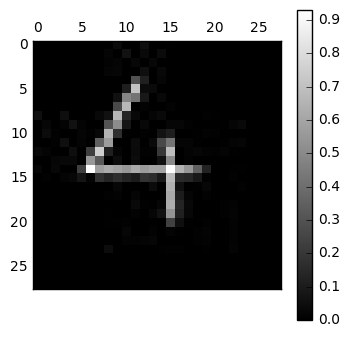

(1, 28, 28)


In [4]:
# Load a test handwritten image 
cwd = os.getcwd()
testImage = PIL.Image.open("./sompic.jpg")
imgArray = np.array(testImage)
imgArray = np.asfarray(imgArray, dtype='float32')
imgArray = imgArray - 255
imgArray = imgArray * -1
imgArray = imgArray/255
#imgArray = imgArray + 0.00000000001
plt.matshow(imgArray[:,:], cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()
imgArray = np.reshape(imgArray,[1,28,28])
print imgArray.shape

In [5]:

# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [6]:
def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    
    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(0, n_steps, x)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()

In [7]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc)
        step += 1
    print "Optimization Finished!"

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print "Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label})
    print sess.run(pred,feed_dict={x:imgArray})

Iter 1280, Minibatch Loss= 1.884873, Training Accuracy= 0.38281
Iter 2560, Minibatch Loss= 1.435738, Training Accuracy= 0.53125
Iter 3840, Minibatch Loss= 1.463890, Training Accuracy= 0.55469
Iter 5120, Minibatch Loss= 1.167752, Training Accuracy= 0.60156
Iter 6400, Minibatch Loss= 0.705191, Training Accuracy= 0.76562
Iter 7680, Minibatch Loss= 0.929666, Training Accuracy= 0.71875
Iter 8960, Minibatch Loss= 1.038900, Training Accuracy= 0.71094
Iter 10240, Minibatch Loss= 0.521947, Training Accuracy= 0.85156
Iter 11520, Minibatch Loss= 0.460162, Training Accuracy= 0.88281
Iter 12800, Minibatch Loss= 0.564338, Training Accuracy= 0.78906
Iter 14080, Minibatch Loss= 0.445497, Training Accuracy= 0.85938
Iter 15360, Minibatch Loss= 0.253168, Training Accuracy= 0.92969
Iter 16640, Minibatch Loss= 0.323470, Training Accuracy= 0.92188
Iter 17920, Minibatch Loss= 0.242178, Training Accuracy= 0.92969
Iter 19200, Minibatch Loss= 0.483390, Training Accuracy= 0.85156
Iter 20480, Minibatch Loss= 0.34

In [ ]:
As we can see it predicts 4 